In [634]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import statsmodels.api as other_sm
import json
import csv
from scipy.stats.stats import pearsonr

%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [635]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [636]:
with open("boxofficemojo_final_dictionary.json", "rb") as json_file:
    main_dict = json.load(json_file)

In [637]:
#destroys main_dict so need to reload the above every time before running this
single_headers = ['title', 'runtime', 'rating', 'studio','opening date', 'opening gross', 'opening theaters', 
 'total gross', 'total theaters', 'boxofficemojo url']
genrelist = []
actorlist = []
singlevaluedict = {}
for title, movie in main_dict.iteritems():
    if 'genres' in movie: genrelist.append([title] + movie.pop('genres'))
    if 'actors' in movie: actorlist.append([title] + movie.pop('actors'))
    singlevaluedict.update({title: [movie.get(header,'unknown') for header in single_headers]})

##Genres

In [638]:
mylist=[]
for row in genrelist:
    for values in row:
        if row[0] != values:
            mylist.append([row[0], values])
genre_df = pd.DataFrame(mylist)
genre_df.columns = ['title', 'genre']
# genre_df['genre'].value_counts()

In [639]:
# with open("violent_categories_revised.txt", "rb") as f:
#     v_list = f.read().splitlines()

# v_genres = [i.strip() for i in v_list]

# violent_movies_by_genre = genre_df[(genre_df['genre'].isin(v_list))]
# score_list = []
# for item in genre_df['genre'].values.tolist():
#     if item in v_genres:
#         score_list.append(3)
#     else:
#         score_list.append(1)
##make new rating with multiplication and rated genres
genre_scores = {}
with open("violent_categories_revised_dict.txt", "rb") as f:
    for i in f:
        genre_scores.update(eval(i))

#add the score column with scores
genre_score_list = []
for item in genre_df['genre'].values.tolist():
    if item in genre_scores:
        genre_score_list.append(genre_scores[item])
    else:
        genre_score_list.append(1)
genre_df['genre score'] = genre_score_list
# genre_scored_movies[(genre_df['title'] == 'Kick-Ass')]

In [640]:
genre_scored_movies = genre_df.copy()
genre_scored_movies = genre_scored_movies.groupby('title').aggregate(np.prod)
# genre_scored_movies.sort('genre score', ascending=False)

##Rating

In [641]:
single_value_df = pd.DataFrame(singlevaluedict)
single_value_df = single_value_df.T
single_value_df.columns = single_headers
# single_value_df['rating'].value_counts()

In [642]:
#get all the rows where rating column equals 'n/a'
# single_value_df[(single_value_df['rating']=='n/a')]

In [643]:
rating_scores = {}
with open("ratings_rated.txt", "rb") as f:
    for i in f:
        rating_scores.update(eval(i))

#add the score column with scores
rating_score_list = []
for item in single_value_df['rating'].values.tolist():
    rating_score_list.append(rating_scores[item])
rating_scored_movies = single_value_df.copy()
rating_scored_movies['rating score'] = rating_score_list
# rating_scored_movies.sort('rating score', ascending=False)

##Body Count

In [644]:
with open("moviebodycounts_final_movie_data_second_clean.json", "rb") as json_file:
    body_count_dict = json.load(json_file)

In [645]:
body_count_df = pd.DataFrame(body_count_dict)
body_count_df = body_count_df.T.convert_objects(convert_numeric=True)
# body_count_df.sort('body count', ascending=False)

In [646]:
body_count_score_list = []
for item in single_value_df['title'].values.tolist():
    if item in body_count_dict:
        body_count_score_list.append(int(body_count_dict[item]['body count']))
    else:
        body_count_score_list.append(None)
body_count_scored_movies = single_value_df.copy()
body_count_scored_movies['body count score'] = body_count_score_list
# body_count_scored_movies.sort('body count score', ascending=False)

##Total Index

In [647]:
total_index = single_value_df.copy()
total_index['genre score'] = genre_scored_movies['genre score']
total_index['normalized genre score'] = genre_scored_movies['genre score'].div(512)
# total_index.sort('normalized genre score', ascending=False)
total_index['rating score'] = rating_scored_movies['rating score']
total_index['normalized rating score'] = rating_scored_movies['rating score'].div(7)
# body_count_scored_movies['body count score'].convert_objects(convert_numeric=True)
total_index['body count score'] = body_count_scored_movies['body count score']
total_index['normalized body count score'] =  body_count_scored_movies['body count score'].div(836)
total_index['violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized body count score']
total_index = total_index.dropna(subset=['genre score'])

In [648]:
test_series = total_index.groupby(['genre score']).mean()["body count score"]

test_indices = test_series.index
# print test_indices.tolist()
null_indices = [i for i, x in enumerate(test_series) if pd.isnull(x)]#test_series[pd.isnull(test_series)].index.tolist())]
# print null_indices
#print test_series.iloc[null_indices])
replacements = [x-1 for x in null_indices]
# print test_series.iloc[replacements]
# print 'replacements', replacements
# print 
# print test_series

#for i in total_index.groupby('genre score').mean()['body count score']:
#     if isnull(i):
# print 'worked?', test_series.replace(test_series.iloc[null_indices], test_series.iloc[replacements])
this_dict = dict(test_series)
this_dict[72] = 57.875
this_dict[96] = 37.0
this_dict[162] = 104.5
this_dict[192] = 104.5
this_dict[256] = 35.0
    
# this_dict

In [649]:
temp_list = [] 
headers = total_index.columns.values

for _, item in total_index.iterrows():#['title'].head(200):
#     {header:item[index] for index,header in enumerate(headers)}

    if pd.isnull(item['body count score']):
        genre_comparison_score = item['genre score']
        body_transfer = this_dict[genre_comparison_score]
        temp_list.append(body_transfer)
    else:
        temp_list.append(item['body count score'])
# temp_list

In [650]:
## replace body count score nan values interpolated by comparison to a similar movie
total_index['implied body count score'] = temp_list

In [651]:
total_index['normalized implied body count score'] = total_index['implied body count score'].div(836)
total_index['implied violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized implied body count score']

In [676]:
# total_index.sort('implied violence index', ascending=False)


,title,runtime,rating,studio,opening date,opening gross,opening theaters,total gross,total theaters,boxofficemojo url,...,normalized genre score,rating score,normalized rating score,body count score,normalized body count score,violence index,implied body count score,normalized implied body count score,implied violence index,violence rank
Resident Evil: Extinction,Resident Evil: Extinction,1 hrs. 35 min.,R,SGem,9/21/2007,"$23,678,580","2,828","$50,648,679","2,848",http://www.boxofficemojo.com/movies/?id=reside...,...,1.000000,5,0.714286,124,0.148325,1.862611,124.000000,0.148325,1.862611,1.0
Resident Evil: Retribution,Resident Evil: Retribution,1 hrs. 35 min.,R,SGem,9/14/2012,"$21,052,227","3,012","$42,345,531","3,016",http://www.boxofficemojo.com/movies/?id=reside...,...,1.000000,5,0.714286,NaN,NaN,NaN,123.500000,0.147727,1.862013,3.0
Resident Evil,Resident Evil,1 hrs. 34 min.,R,SGem,3/15/2002,"$17,707,106","2,528","$40,119,709","2,528",http://www.boxofficemojo.com/movies/?id=reside...,...,1.000000,5,0.714286,NaN,NaN,NaN,123.500000,0.147727,1.862013,3.0
Resident Evil: Afterlife,Resident Evil: Afterlife,1 hrs. 40 min.,R,SGem,9/10/2010,"$26,650,264","3,203","$60,128,566","3,209",http://www.boxofficemojo.com/movies/?id=reside...,...,1.000000,5,0.714286,NaN,NaN,NaN,123.500000,0.147727,1.862013,3.0
Resident Evil: Apocalypse,Resident Evil: Apocalypse,1 hrs. 34 min.,R,SGem,9/10/2004,"$23,036,273","3,284","$51,201,453","3,284",http://www.boxofficemojo.com/movies/?id=reside...,...,1.000000,5,0.714286,123,0.147129,1.861415,123.000000,0.147129,1.861415,5.0
Kill Bill Vol. 1,Kill Bill Vol. 1,1 hrs. 50 min.,R,Mira.,10/10/2003,"$22,089,322","3,102","$70,099,045","3,102",http://www.boxofficemojo.com/movies/?id=killbi...,...,0.632812,5,0.714286,95,0.113636,1.460735,95.000000,0.113636,1.460735,6.0
Kingdom of Heaven,Kingdom of Heaven,2 hrs. 25 min.,R,Fox,5/6/2005,"$19,635,996","3,216","$47,398,413","3,219",http://www.boxofficemojo.com/movies/?id=kingdo...,...,0.001953,5,0.714286,610,0.729665,1.445904,610.000000,0.729665,1.445904,7.0
Blade: Trinity,Blade: Trinity,1 hrs. 54 min.,R,NL,12/8/2004,"$16,061,271","2,912","$52,411,906","2,912",http://www.boxofficemojo.com/movies/?id=blade3...,...,0.562500,5,0.714286,140,0.167464,1.444250,140.000000,0.167464,1.444250,8.0
300,300,1 hrs. 57 min.,R,WB,3/9/2007,"$70,885,301","3,103","$210,614,939","3,280",http://www.boxofficemojo.com/movies/?id=300.htm,...,0.011719,5,0.714286,600,0.717703,1.443708,600.000000,0.717703,1.443708,9.0
The Lord of the Rings: The Return of the King,The Lord of the Rings: The Return of the King,3 hrs. 20 min.,PG-13,NL,12/17/2003,"$72,629,713","3,703","$377,027,325*","3,703",http://www.boxofficemojo.com/movies/?id=return...,...,0.005859,3,0.428571,836,1.000000,1.434431,836.000000,1.000000,1.434431,10.0


In [653]:
total_index['violence rank'] = total_index['implied violence index'].rank(ascending=False)

In [654]:
# total_index.sort('implied violence index', ascending=False)

##Chicago is a wasteland

In [655]:
crime_df = pd.DataFrame.from_csv('Crimes_-_2001_to_present.csv', infer_datetime_format=True)
# crime_df

In [656]:
crime_df['day'] = pd.to_datetime(crime_df['Date'], format="%m/%d/%Y", exact=False, dayfirst=True)

In [657]:
# crime_df

In [658]:
v_crimes_per_day = crime_df.groupby('day').count()
v_crimes_per_day = v_crimes_per_day.reset_index()

In [659]:
# crime_df.dtypes

In [660]:
# total_index[(total_index['opening date'] == '9/26/2008')]


In [661]:
# ##error correction
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]
# total_index = total_index[(total_index['opening date'] != 'Jan 2013')]
# total_index = total_index[(total_index['opening date'] != 'TBD')]
# total_index = total_index[(total_index['opening date'] != '1966')]
# total_index = total_index[(total_index['opening date'] != '1987')]
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]

In [662]:
v_crimes_per_day = v_crimes_per_day.set_index('day')

In [663]:
v_crimes_per_day = v_crimes_per_day['Primary Type']

In [664]:
# v_crimes_per_day

In [665]:
total_index_graph = total_index.copy()
total_index_graph['opening date'] = pd.to_datetime(total_index_graph['opening date'], dayfirst=True, coerce=True)
total_index_graph = total_index_graph[(total_index_graph['opening date'].dt.year > 2000) & (total_index_graph['opening date'].dt.year < 2016)].sort('opening date')

v_movies_per_day = total_index_graph.groupby('opening date').sum()
v_movies_per_day = v_movies_per_day['implied violence index']
# v_movies_per_day = total_index_graph['implied violence index']

In [682]:
total_index_graph.head()

,title,runtime,rating,studio,opening date,opening gross,opening theaters,total gross,total theaters,boxofficemojo url,...,normalized genre score,rating score,normalized rating score,body count score,normalized body count score,violence index,implied body count score,normalized implied body count score,implied violence index,violence rank
What's the Worst That Could Happen?,What's the Worst That Could Happen?,1 hrs. 39 min.,PG-13,MGM,2001-01-06,"$13,049,114","2,675","$32,269,834","2,675",http://www.boxofficemojo.com/movies/?id=whatst...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
The Animal,The Animal,1 hrs. 23 min.,PG-13,SonR,2001-01-06,"$19,610,520","2,788","$57,743,062","2,788",http://www.boxofficemojo.com/movies/?id=animal...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
Nuit de noces,Nuit de noces,1 hrs. 32 min.,Unrated,Sev.,2001-01-06,"$241,697",75,"$1,238,180",76,http://www.boxofficemojo.com/movies/?id=nuitde...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
Big Eden,Big Eden,1 hrs. 48 min.,PG-13,Jour,2001-01-06,"$40,762",8,"$512,451",10,http://www.boxofficemojo.com/movies/?id=bigede...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
A Real Young Girl,A Real Young Girl,1 hrs. 33 min.,Unrated,CinV,2001-01-06,n/a,n/a,"$17,245",n/a,http://www.boxofficemojo.com/movies/?id=realyo...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5


In [707]:
test_theaters = None
test_theaters = total_index_graph["opening theaters"].str.replace(",", "").convert_objects(convert_numeric=True)
test_theaters = other_sm.add_constant(test_theaters)
test_theaters["rating score"] = total_index_graph["rating score"]
test_theaters["implied body count score"] = total_index_graph["implied body count score"]
test_opening_gross = total_index_graph["opening gross"].str.replace("[,$]", "").convert_objects(convert_numeric=True)
print test_theaters.head(2)

results = other_sm.OLS(test_opening_gross,test_theaters, missing='drop').fit()

results.summary()
#plt.scatter(total_index_graph["body count score"], test_theaters)
# total_index_graph.dtypes



                                     const  opening theaters  rating score  \
What's the Worst That Could Happen?      1              2675             3   
The Animal                               1              2788             3   

                                     implied body count score  
What's the Worst That Could Happen?                 58.946809  
The Animal                                          58.946809  


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          opening gross   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     3361.
Date:                Wed, 22 Apr 2015   Prob (F-statistic):               0.00
Time:                        20:04:56   Log-Likelihood:            -1.3705e+05
No. Observations:                7851   AIC:                         2.741e+05
Df Residuals:                    7847   BIC:                         2.741e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                    -3.007e+06   4.95e+05     -6.070      0.000     -3.98e+06 -2.04e+06
opening theaters          8827.3233     99.551     88.671      0.000      8632.176  9022.470
rating score              2.775e+05   8.18e+04      3.393      0.001      1.17e+05  4.38e+05
implied body count score  1.318e+04   4527.529      2.910      0.004      4300.001  2.21e+04
==============================================================================
Omnibus:                     9394.250   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1721781.086
Skew:                           6.236   Prob(JB):                         0.00
Kurtosis:                      74.469   Cond. No.                     6.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# v_movies_per_day

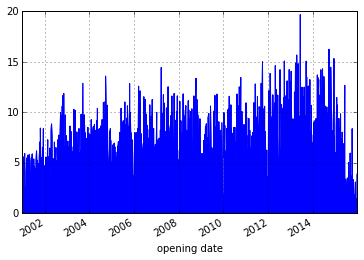

In [530]:
v_movies_per_day.plot(kind='area')

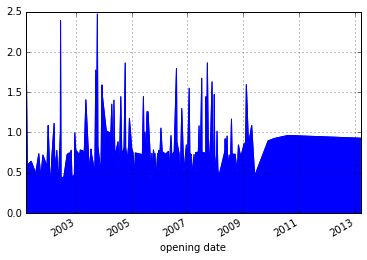

In [531]:
##graphs with nan values removed and not interpolated
no_nan_graph = total_index_graph.groupby('opening date').sum()
no_nan_graph = no_nan_graph['violence index'].dropna()
no_nan_graph.plot(kind='area')

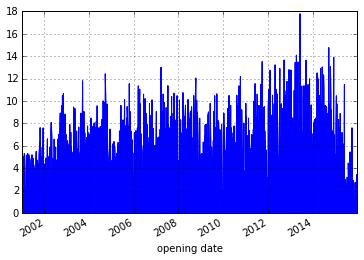

In [532]:
##graphs with nan values set to 1 and not interpolated
nan_1_graph = total_index_graph.groupby('opening date').sum()
nan_1_graph['body count score'] = nan_1_graph['body count score'].fillna(1)
nan_1_graph['normalized body count score'] =  nan_1_graph['body count score'].div(836)
nan_1_graph['violence index'] = nan_1_graph['normalized genre score'] + nan_1_graph['normalized rating score'] + nan_1_graph['normalized body count score']
nan_1_graph = nan_1_graph['violence index']
nan_1_graph.plot(kind='area')

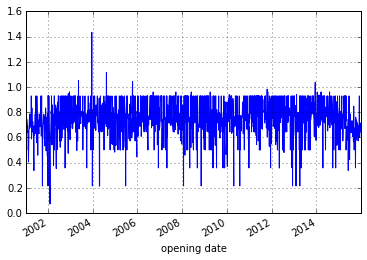

In [533]:
##original graph with the average violent movie rating for each day rather than the total violent movie rating per day
mean_graph = total_index_graph.groupby('opening date').mean()
mean_graph = mean_graph['implied violence index']
mean_graph.plot()

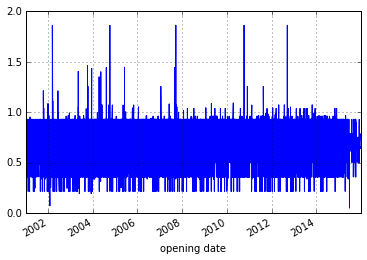

In [534]:
## each movie stands alone for each day alone rather than getting summed
stand_alone_graph = total_index_graph.copy()
stand_alone_graph = stand_alone_graph.set_index('opening date')
stand_alone_graph = stand_alone_graph['implied violence index']
stand_alone_graph.plot()

In [535]:
## each movie score extends out for seven days from the release date instead of just the opening date
import datetime
five_day_graph = total_index_graph.copy()
five_day_graph = five_day_graph.set_index(['title', 'opening date'])
new_rows = []
for row in five_day_graph.iterrows():
    for i in range(1,7):
        title , date = row[0]
        new_date = date + datetime.timedelta(days=i)
        new_row = five_day_graph.loc[(title, date)]
        new_row.name = (title, new_date)
        new_rows.append(new_row)
five_day_graph = five_day_graph.append(new_rows)
five_day_graph = five_day_graph.sort_index()


In [536]:
five_day_graph = five_day_graph.reset_index()
five_day_graph_no_nan = five_day_graph.copy()
# seven_day_graph = five_day_graph.copy()
three_day_graph = five_day_graph.copy()

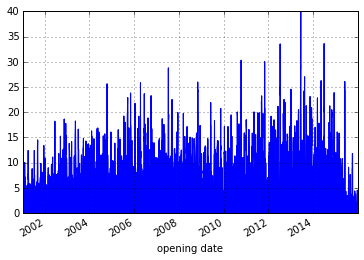

In [537]:
#7 day with interpolation
five_day_graph_i = five_day_graph.groupby('opening date').sum()
five_day_graph_i = five_day_graph_i['implied violence index']
five_day_graph_i.plot(kind='area')


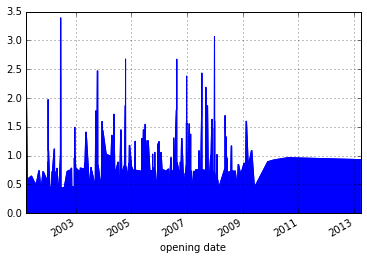

In [538]:
#7 day without interpolation
five_day_graph_no_nan = five_day_graph_no_nan.groupby('opening date').sum()
five_day_graph_no_nan = five_day_graph_no_nan['violence index'].dropna()
five_day_graph_no_nan.plot(kind='area')

In [559]:
# seven_day_graph

In [553]:
# seven_day_graph = seven_day_graph.reset_index()
# seven_day_graph_no_nan = seven_day_graph.copy()

In [560]:
# #7 day reducing with interpolation
# seven_day_graph_i = seven_day_graph.groupby('opening date').sum()
# seven_day_graph_i = seven_day_graph_i['reducing implied violence index']
# seven_day_graph_i.plot(kind='area')


In [561]:
# #7 day reducing without interpolation
# seven_day_graph_no_nan = seven_day_graph_no_nan.groupby('opening date').sum()
# seven_day_graph_no_nan = seven_day_graph_no_nan['reducing violence index'].dropna()
# seven_day_graph_no_nan.plot(kind='area')

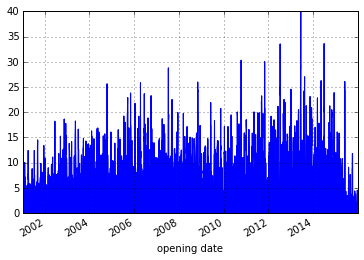

In [543]:
#7 day with interpolation
three_day_graph_i = three_day_graph.groupby('opening date').sum()
three_day_graph_i = three_day_graph_i['implied violence index']
three_day_graph_i.plot(kind='area')

In [544]:
## meaning of life graph
# mol_graph = total_index_graph.groupby('opening date')
# mol_graph = mol_graph['implied violence index']
# mol_graph.plot(figsize=(20,5))

In [545]:
# v_movies_per_day

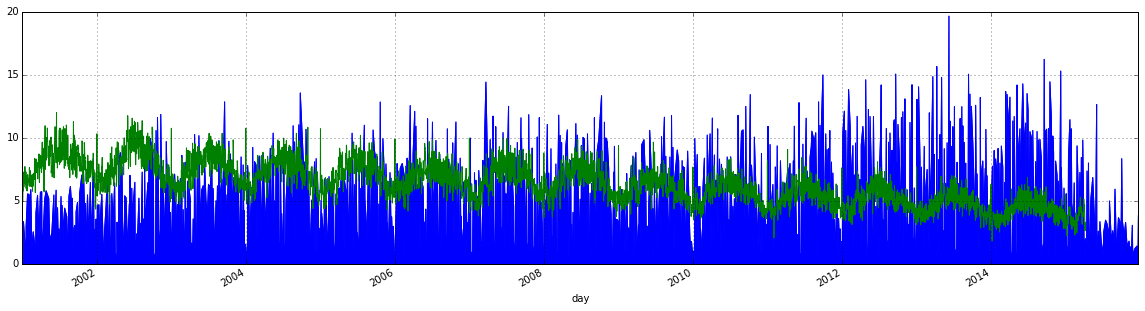

In [546]:
##original
v_movies_per_day.plot(kind='area')
v_crimes_per_day.div(50).plot(figsize=(20,5), kind='line')

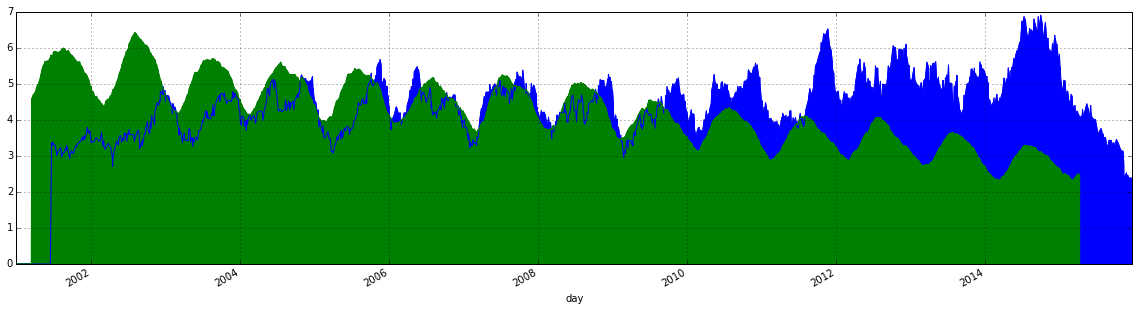

In [580]:
pd.rolling_mean(v_movies_per_day, window=30).plot(kind='area')
pd.rolling_mean(v_crimes_per_day.div(75), window=75).plot(figsize=(20,5), kind='area')

In [562]:
# stand_alone_g = total_index_graph.copy()
# stand_alone_g = stand_alone_g.set_index('opening date')
# stand_alone_g = stand_alone_g['implied violence index']
# pd.rolling_mean(stand_alone_g, window=75).plot(kind='area')
# pd.rolling_mean(v_crimes_per_day.div(500), window=75).plot(figsize=(20,5), kind='area')

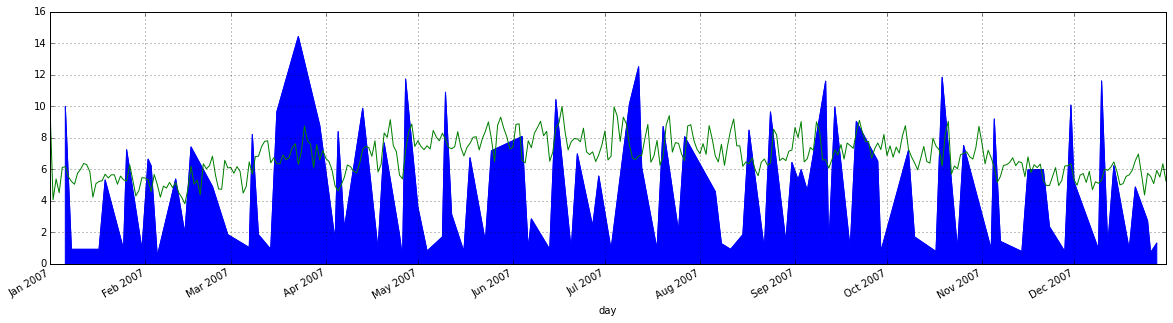

In [563]:
v_movies_per_day['2007':'2007'].plot(kind='area')
v_crimes_per_day.div(50)['2007':'2007'].plot(figsize=(20,5), kind='line')

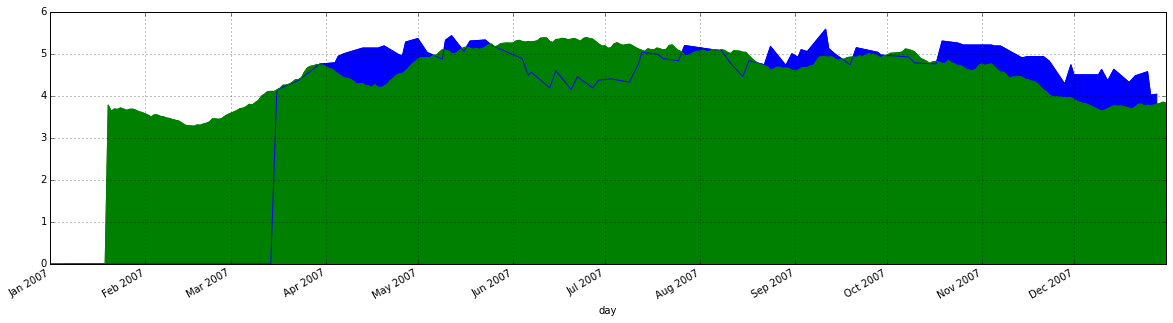

In [564]:
pd.rolling_mean(v_movies_per_day['2007':'2007'], window=20).plot(kind='area')
pd.rolling_mean(v_crimes_per_day['2007':'2007'].div(75), window=20).plot(figsize=(20,5), kind='area')

In [551]:
# five_day_graph_no_nan

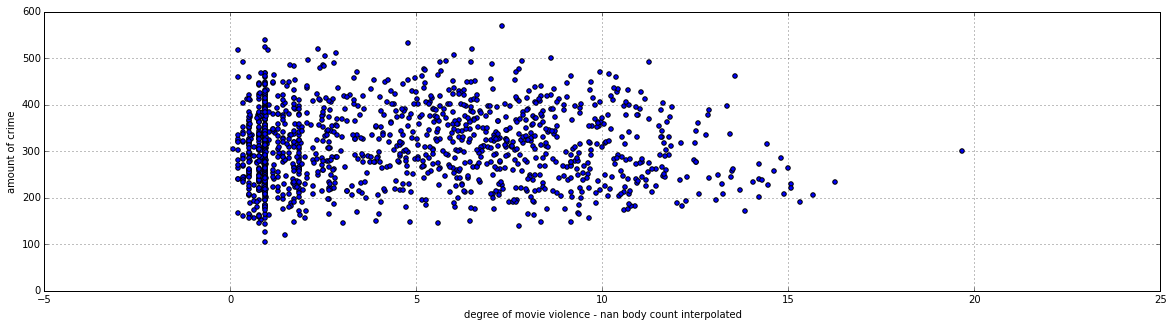

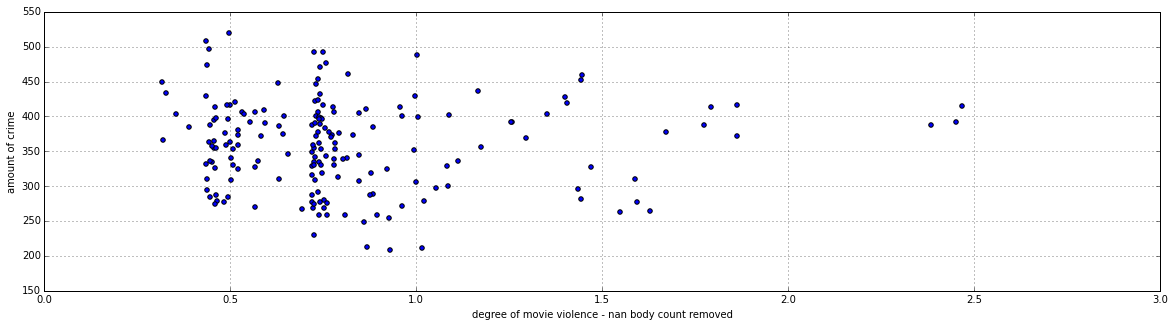

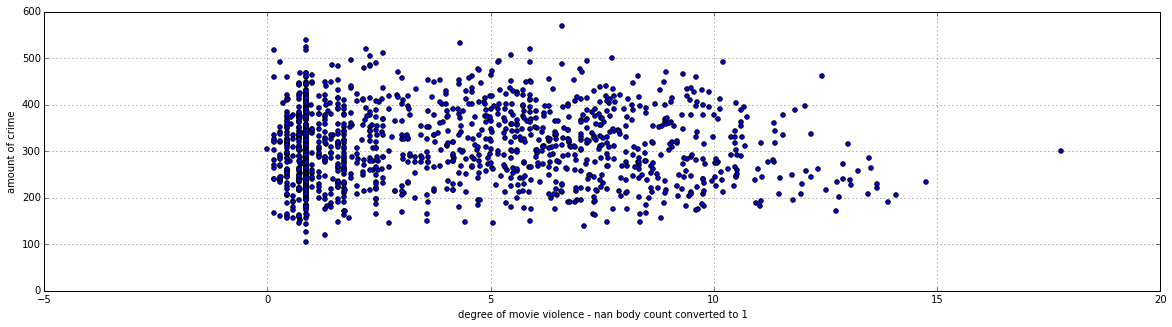

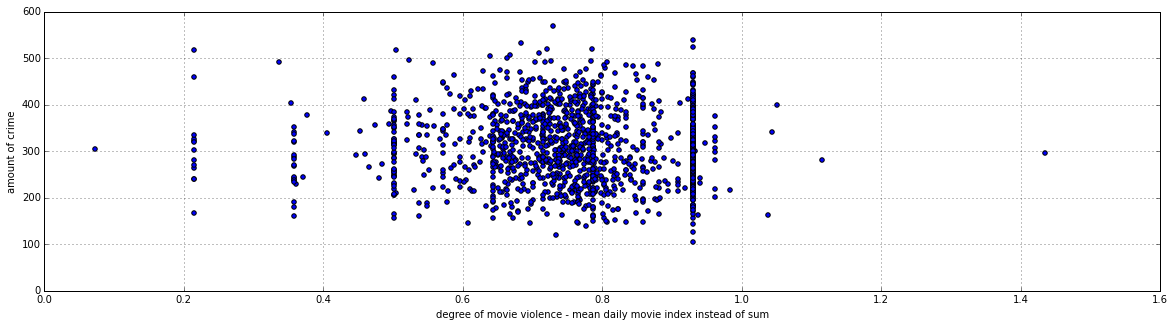

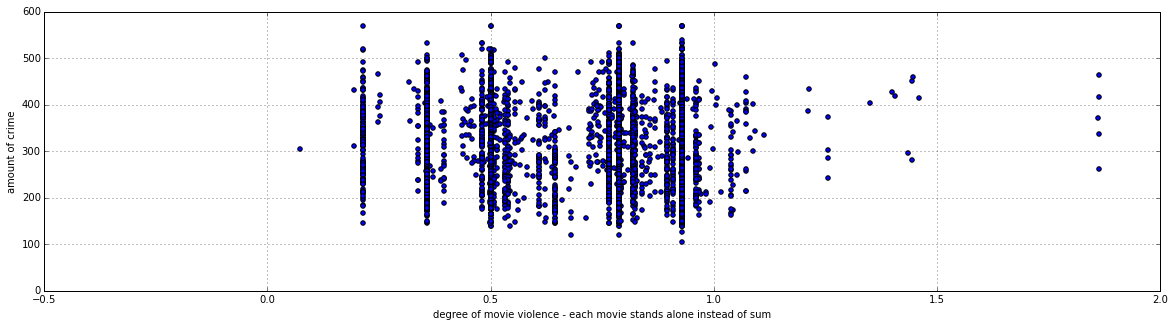

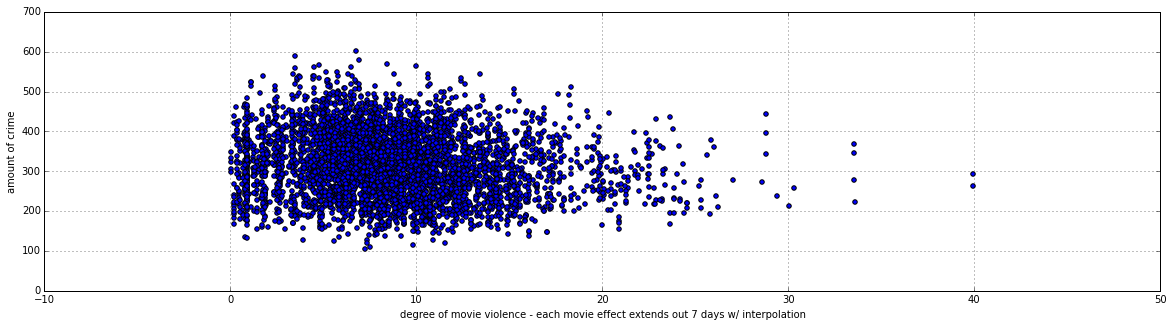

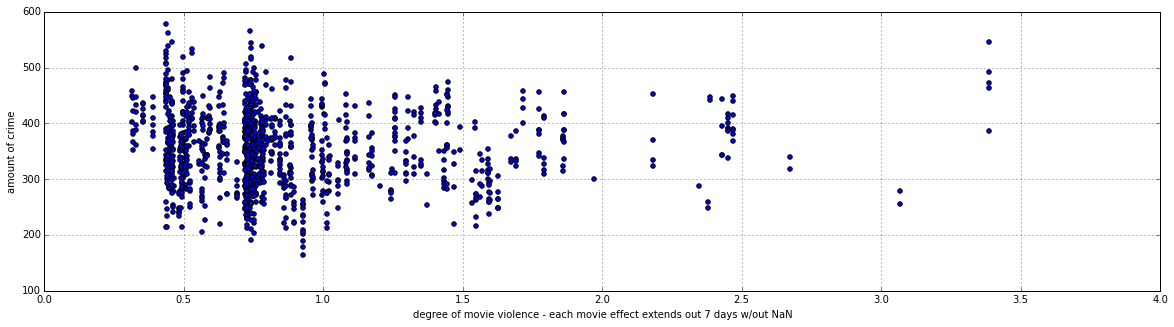

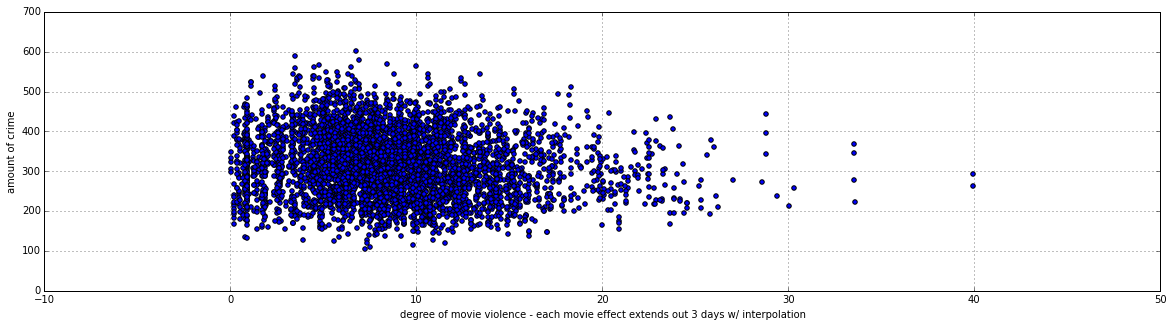

In [581]:
final_annoying_data = pd.DataFrame(v_movies_per_day).join(v_crimes_per_day).dropna()
ax = final_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
ax.set_ylabel("amount of crime")
ax.set_xlabel("degree of movie violence - nan body count interpolated")

## nan body counts removed instead of interpolated
no_nan_final_annoying_data = pd.DataFrame(no_nan_graph).join(v_crimes_per_day).dropna()
no_nan_ax = no_nan_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
no_nan_ax.set_ylabel("amount of crime")
no_nan_ax.set_xlabel("degree of movie violence - nan body count removed")

## nan body counts converted to 1
nan_1_final_annoying_data = pd.DataFrame(nan_1_graph).join(v_crimes_per_day).dropna()
nan_1_ax = nan_1_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
nan_1_ax.set_ylabel("amount of crime")
nan_1_ax.set_xlabel("degree of movie violence - nan body count converted to 1")

## mean graph for movies instead of sum of movie index per day
mean_annoying_data = pd.DataFrame(mean_graph).join(v_crimes_per_day).dropna()
mean_ax = mean_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
mean_ax.set_ylabel("amount of crime")
mean_ax.set_xlabel("degree of movie violence - mean daily movie index instead of sum")

## each movies stands alone instead of sum of movie index per day
stand_alone_annoying_data = pd.DataFrame(stand_alone_graph).join(v_crimes_per_day).dropna()
stand_alone_ax = stand_alone_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
stand_alone_ax.set_ylabel("amount of crime")
stand_alone_ax.set_xlabel("degree of movie violence - each movie stands alone instead of sum")

## each movie violence index extends out seven days with interpolation
five_day_data = pd.DataFrame(five_day_graph_i).join(v_crimes_per_day).dropna()
five_day_ax = five_day_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
five_day_ax.set_ylabel("amount of crime")
five_day_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/ interpolation")

## each movie violence index extends out seven days with nan values removed
five_day_data_no_nan = pd.DataFrame(five_day_graph_no_nan).join(v_crimes_per_day).dropna()
five_day_no_nan_ax = five_day_data_no_nan.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
five_day_no_nan_ax.set_ylabel("amount of crime")
five_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/out NaN")

# ## each movie violence index extends out seven days with interpolation and reduces
# seven_day_data = pd.DataFrame(seven_day_graph_i).join(v_crimes_per_day).dropna()
# seven_day_ax = seven_day_data.plot(y='Primary Type', x="reducing implied violence index", kind = "scatter", figsize=(20,5))
# seven_day_ax.set_ylabel("amount of crime")
# seven_day_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/ interpolation and reducing")

# ## each movie violence index extends out seven days with nan values removed and reduces
# seven_day_data_no_nan = pd.DataFrame(seven_day_graph_no_nan).join(v_crimes_per_day).dropna()
# seven_day_no_nan_ax = seven_day_data_no_nan.plot(y='Primary Type', x="reducing violence index", kind='scatter',figsize=(20,5))
# seven_day_no_nan_ax.set_ylabel("amount of crime")
# seven_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/out NaN and reducing")

## three day extension
three_day_data_no_nan = pd.DataFrame(three_day_graph_i).join(v_crimes_per_day).dropna()
three_day_no_nan_ax = three_day_data_no_nan.plot(y='Primary Type', x="implied violence index", kind='scatter',figsize=(20,5))
three_day_no_nan_ax.set_ylabel("amount of crime")
three_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 3 days w/ interpolation")



In [ ]:
X=mean_annoying_data["implied violence index"]
Y=mean_annoying_data['Primary Type']
pearsonr(X, Y)

In [333]:
s = v_movies_per_day

#standard deviation for outliers
print  s.std()
#bool for those in the series exceeeding std dev
print s > s.std() * 3
#items which exceed std dev
print s[s > s.std() * 3]
#remove outliers from series
final_annoying_data.drop([s > s.std() * 3])

# s > s.std() * 3
# final_annoying_data = pd.DataFrame(v_movies_per_day).join(v_crimes_per_day).dropna()
# ax = final_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
# ax.set_ylabel("amount of crime")
# ax.set_xlabel("degree of movie violence - nan body count interpolated")

3.77614855193
opening date
2001-01-06    False
2001-01-18    False
2001-01-19    False
2001-01-26    False
2001-02-02    False
2001-02-03    False
2001-02-11    False
2001-02-16    False
2001-02-23    False
2001-03-07    False
2001-03-08    False
2001-03-16    False
2001-03-23    False
2001-03-30    False
2001-04-03    False
2001-04-05    False
2001-04-07    False
2001-04-13    False
2001-04-20    False
2001-04-27    False
2001-05-10    False
2001-05-16    False
2001-05-18    False
2001-05-25    False
2001-06-04    False
2001-06-06    False
2001-06-07    False
2001-06-15    False
2001-06-16    False
2001-06-22    False
              ...  
2015-07-17    False
2015-07-24    False
2015-07-31    False
2015-08-04    False
2015-08-05    False
2015-08-14    False
2015-08-21    False
2015-08-28    False
2015-09-01    False
2015-09-09    False
2015-09-10    False
2015-09-18    False
2015-09-25    False
2015-09-30    False
2015-10-04    False
2015-10-07    False
2015-10-16    False
2015-10-23   

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [710]:
X=final_annoying_data['implied violence index']
Y=final_annoying_data['Primary Type']
X = other_sm.add_constant(X)

# final_annoying_data

(-0.014449352946909737, 0.59268663522320175)

In [711]:
results = sm.OLS( Y, X).fit()
results.summary()
# plt.scatter(X,Y)
# X_plot = np.linspace(0,1,100)
# plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2863
Date:                Wed, 22 Apr 2015   Prob (F-statistic):              0.593
Time:                        20:14:30   Log-Likelihood:                -7952.0
No. Observations:                1373   AIC:                         1.591e+04
Df Residuals:                    1371   BIC:                         1.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                    312.2377      3.323     93.958      0.000       305.719   318.757
implied violence index    -0.3016      0.564     -0.535      0.593        -1.407     0.804
==============================================================================
Omnibus:                       27.647   Durbin-Watson:                   0.430
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.100
Skew:                           0.191   Prob(JB):                     4.32e-05
Kurtosis:                       2.547   Cond. No.                         9.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [613]:
## no nan body count
no_nan_X=no_nan_final_annoying_data['violence index'].dropna()
no_nan_Y=no_nan_final_annoying_data['Primary Type'].dropna()
no_nan_results = sm.OLS( no_nan_Y, no_nan_X).fit()
no_nan_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     687.3
Date:                Wed, 22 Apr 2015   Prob (F-statistic):           1.56e-63
Time:                        19:14:36   Log-Likelihood:                -1189.0
No. Observations:                 182   AIC:                             2380.
Df Residuals:                     181   BIC:                             2383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index   360.8508     13.764     26.217      0.000       333.692   388.010
==============================================================================
Omnibus:                       39.610   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.008
Skew:                          -1.140   Prob(JB):                     1.26e-14
Kurtosis:                       4.801   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [709]:
## nan body count set to 1
nan_1_X=nan_1_final_annoying_data['violence index'].dropna()
nan_1_Y=nan_1_final_annoying_data['Primary Type'].dropna()
nan_1_results = sm.OLS( nan_1_Y, nan_1_X).fit()
nan_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1651.
Date:                Wed, 22 Apr 2015   Prob (F-statistic):          1.20e-237
Time:                        20:13:39   Log-Likelihood:                -9329.2
No. Observations:                1373   AIC:                         1.866e+04
Df Residuals:                    1372   BIC:                         1.867e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index    44.4652      1.094     40.636      0.000        42.319    46.612
==============================================================================
Omnibus:                       83.286   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.086
Skew:                          -0.655   Prob(JB):                     5.02e-22
Kurtosis:                       2.975   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""